# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import logging
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model',
                                                      'case=3_small_batch_imagenet',
                                                      'case/user=local_updates'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case small_batch_imagenet with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.user.data_idx = 200
cfg.case.model='resnet18'

cfg.case.user.num_local_updates = 8
cfg.case.user.num_data_per_local_update_step = 8
cfg.case.user.num_data_points = 64
cfg.case.user.local_learning_rate = 1e-4

cfg.case.server.model_modification.type = 'SparseImprintBlock' 
cfg.case.server.model_modification.num_bins=128
cfg.case.server.model_modification.position=None


cfg.case.server.has_external_data = False

### Instantiate all parties

In [4]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 50,375,336 parameters and 9,620 buffers.
Overall this is a data ratio of       5:1 for target shape [64, 3, 224, 224] given that num_queries=1.


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserMultiStep with settings:
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 200
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

In [7]:
print(f'Grad norm: {torch.norm(torch.stack([torch.norm(g, 2) for g in shared_data["gradients"][0]]), 2)}')
[(g.norm(), g.std()) for g in shared_data['gradients'][0]]

Grad norm: 3.5775394439697266


[(tensor(0.0786, device='cuda:0'), tensor(1.7898e-05, device='cuda:0')),
 (tensor(0.0002, device='cuda:0'), tensor(1.7651e-05, device='cuda:0')),
 (tensor(0.0005, device='cuda:0'), tensor(1.1421e-07, device='cuda:0')),
 (tensor(5.1185e-05, device='cuda:0'), tensor(1.3120e-07, device='cuda:0')),
 (tensor(0.9607, device='cuda:0'), tensor(0.0098, device='cuda:0')),
 (tensor(0.2915, device='cuda:0'), tensor(0.0350, device='cuda:0')),
 (tensor(0.0046, device='cuda:0'), tensor(0.0006, device='cuda:0')),
 (tensor(0.6527, device='cuda:0'), tensor(0.0034, device='cuda:0')),
 (tensor(0.2021, device='cuda:0'), tensor(0.0246, device='cuda:0')),
 (tensor(0.0085, device='cuda:0'), tensor(0.0011, device='cuda:0')),
 (tensor(0.7246, device='cuda:0'), tensor(0.0038, device='cuda:0')),
 (tensor(0.2376, device='cuda:0'), tensor(0.0288, device='cuda:0')),
 (tensor(0.0085, device='cuda:0'), tensor(0.0011, device='cuda:0')),
 (tensor(0.9025, device='cuda:0'), tensor(0.0047, device='cuda:0')),
 (tensor(0.110

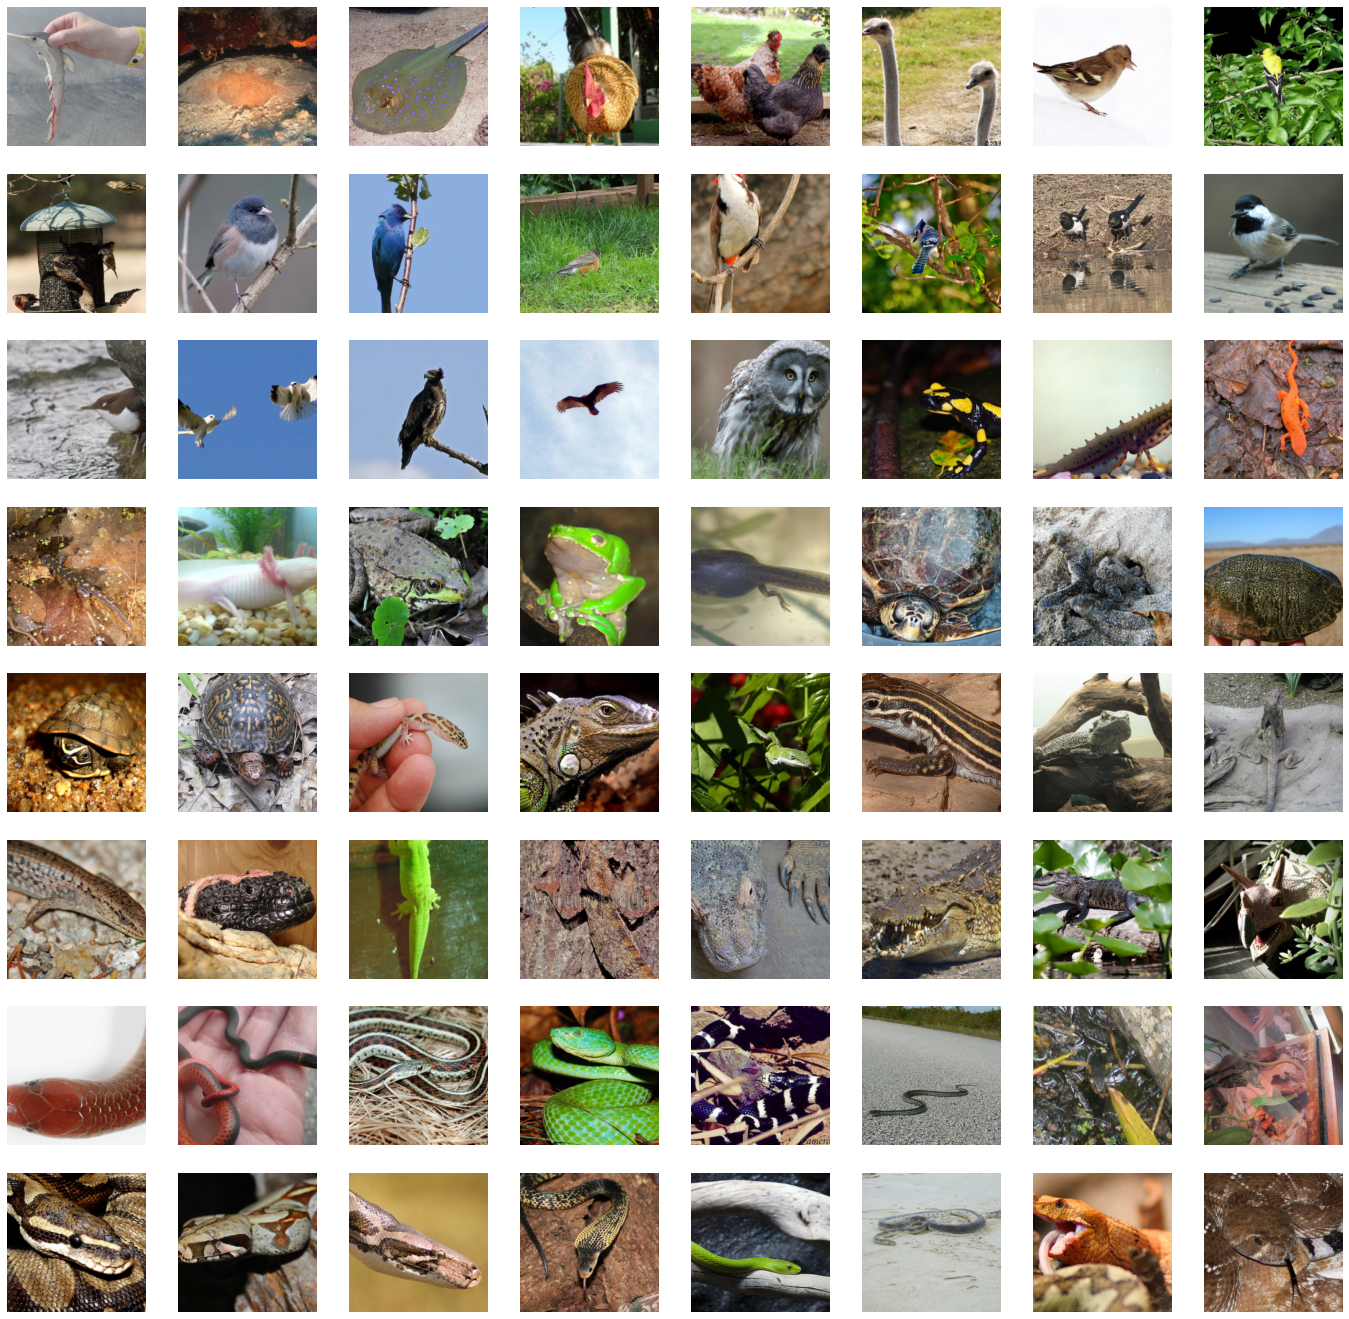

In [8]:
user.plot(true_user_data)

# Reconstruct user data

In [9]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

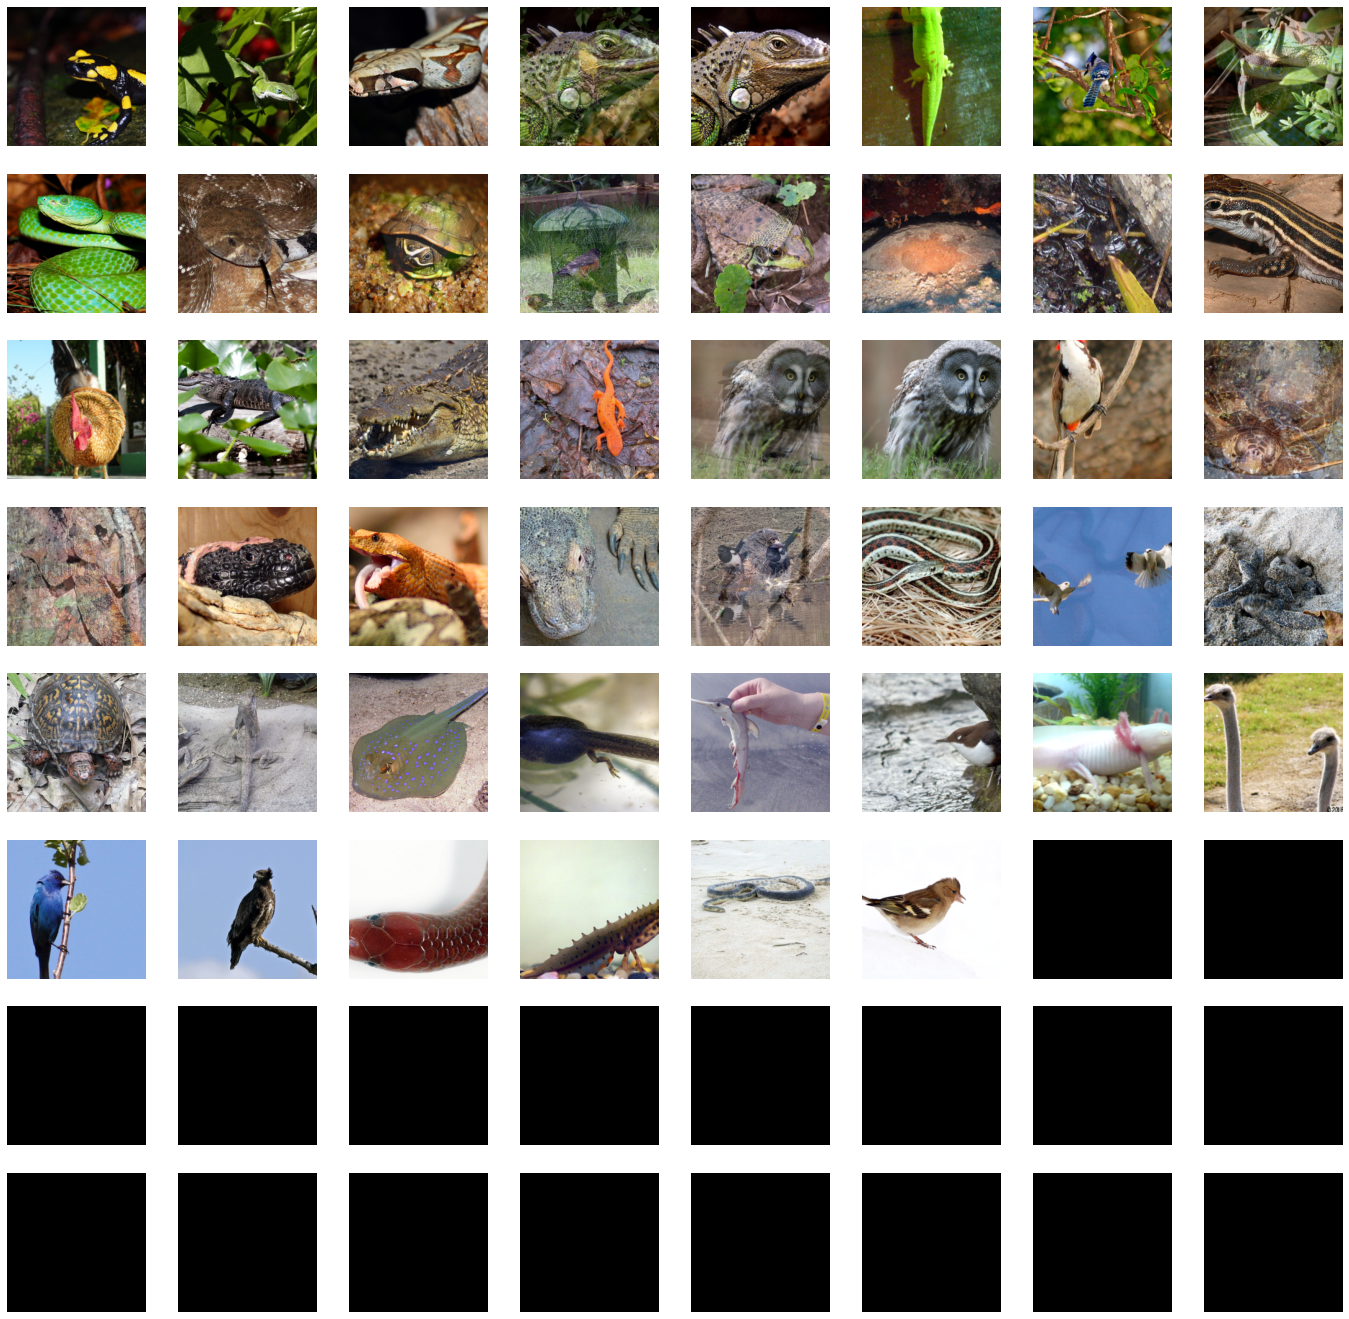

In [10]:
user.plot(reconstructed_user_data, scale=True)

In [11]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False, skip_rpsnr=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0214 | PSNR: 32.65 | FMSE: 7.1163e+00 | LPIPS: 0.31| R-PSNR:  nan | IIP-pixel: 70.31%


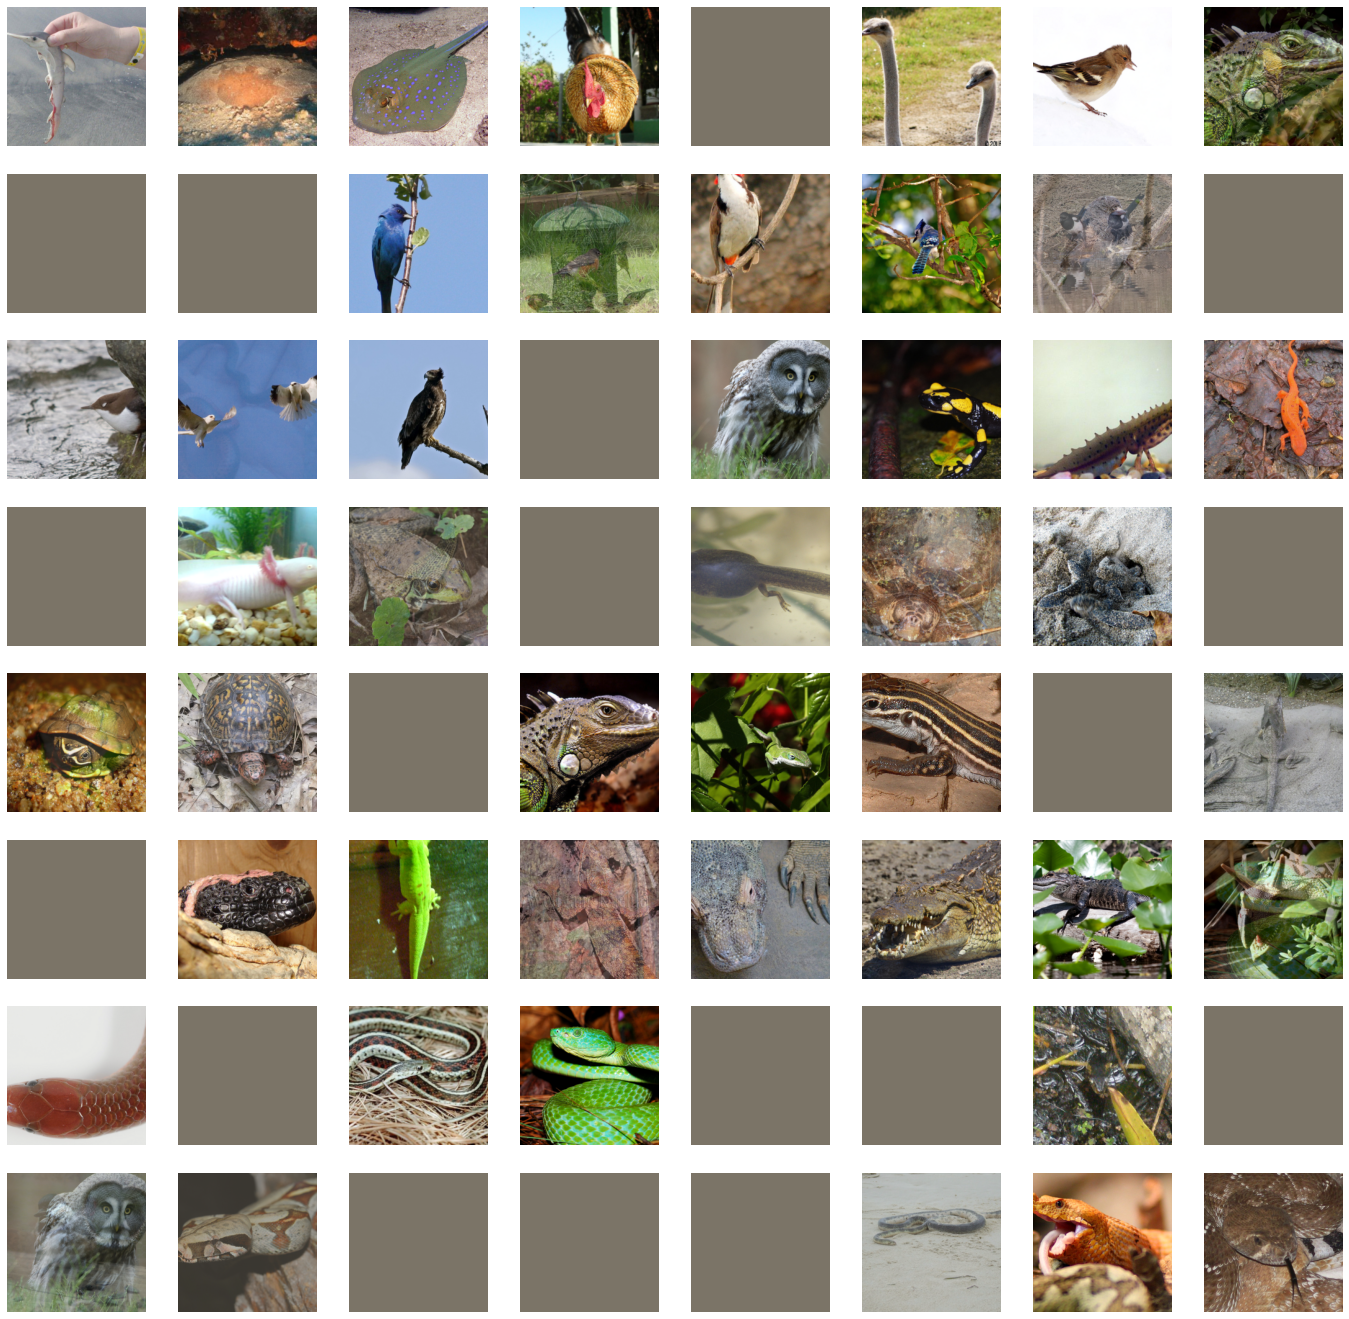

In [12]:
user.plot(reconstructed_user_data, scale=False)